In [1]:
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
from matplotlib import pyplot as plt

# Random Forest Classifiers

## Weather

In [ ]:
# weather analysis for Fresno
Fresno = pd.read_csv("Fresno_accidents.csv")

Fresno["labels"] = Fresno["Severity"] >= 3   # new column for binary severity labels
Fresno = Fresno[['labels', 'Temperature(F)', 'Wind_Chill(F)', 'Pressure(in)', 'Visibility(mi)',
       'Wind_Speed(mph)', 'Precipitation(in)', 'Humidity(%)']]

# get train and test data
shuffled = Fresno.sample(frac=1, random_state=21)
groups = np.array_split(shuffled, 3)

X = groups[0].to_numpy().astype(float)
X_train, y_train = X[:, 1:], X[:, 0]

# train a random forest classifier
forest = RandomForestClassifier(oob_score=True)
forest.fit(X_train, y_train)
print(f"\noob score: {forest.oob_score_}")
sorted_importance_fresno = sorted(list(zip(forest.feature_importances_, Fresno.columns[1:-1])))[::-1]
print(f"\nFeature importance: {sorted_importance_fresno}")

# get accuracy score
X1 = groups[1].to_numpy().astype(float)
X_test, y_test = X1[:, 1:], X[:, 0]
pred = forest.predict(X_test)
print(f"\nAccuracy Score: {accuracy_score(pred, y_test)}")

/usr/local/lib/python3.13/site-packages/numpy/_core/fromnumeric.py:57: FutureWarning: 'DataFrame.swapaxes' is deprecated and will be removed in a future version. Please use 'DataFrame.transpose' instead.
  return bound(*args, **kwds)



oob score: 0.9861878453038674

Feature importance: [(np.float64(0.20910077636503074), 'Pressure(in)'), (np.float64(0.16830608721037754), 'Temperature(F)'), (np.float64(0.14120794107768747), 'Wind_Chill(F)'), (np.float64(0.13447717926291305), 'Wind_Speed(mph)'), (np.float64(0.06859587048487265), 'Precipitation(in)'), (np.float64(0.056950269382464634), 'Visibility(mi)')]

Accuracy Score: 0.9834254143646409


In [8]:
# weather analysis for St Louis
StLouis = pd.read_csv("StLouis_accidents.csv")

StLouis["labels"] = StLouis["Severity"] >= 3
StLouis = StLouis[['labels', 'Temperature(F)', 'Wind_Chill(F)', 'Pressure(in)', 'Visibility(mi)',
       'Wind_Speed(mph)', 'Precipitation(in)', 'Humidity(%)']]

# get train and test data
shuffled = StLouis.sample(frac=1, random_state=21)
groups = np.array_split(shuffled, 3)

X = groups[0].to_numpy().astype(float)
X_train, y_train = X[:, 1:], X[:, 0]

# train a random classifier
forest = RandomForestClassifier(oob_score=True)
forest.fit(X_train, y_train)
print(f"\noob score: {forest.oob_score_}")
sorted_importance_stlouis = sorted(list(zip(forest.feature_importances_, list(Fresno.columns[1:]))))[::-1]
print(f"\nFeature importance: {sorted_importance_stlouis}")

# test it
test = groups[1].to_numpy().astype(float)
X_test, y_test = test[:, 1:], test[:, 0]
pred = forest.predict(X_test).round()
score = accuracy_score(y_test, pred)
print(f"\nAccuracy Score: {score}\n")


/usr/local/lib/python3.13/site-packages/numpy/_core/fromnumeric.py:57: FutureWarning: 'DataFrame.swapaxes' is deprecated and will be removed in a future version. Please use 'DataFrame.transpose' instead.
  return bound(*args, **kwds)



oob score: 0.8105263157894737

Feature importance: [(np.float64(0.22692716421711068), 'Pressure(in)'), (np.float64(0.20548519085858094), 'Humidity(%)'), (np.float64(0.19008570730059346), 'Temperature(F)'), (np.float64(0.16562533680239597), 'Wind_Chill(F)'), (np.float64(0.15260915776936806), 'Wind_Speed(mph)'), (np.float64(0.0403016714971936), 'Visibility(mi)'), (np.float64(0.01896577155475743), 'Precipitation(in)')]

Accuracy Score: 0.8014059753954306



In [ ]:
# plot both side by side in a bar plot
importances1 = pd.Series([i for i, _ in sorted_importance_fresno], index=[j for _, j in sorted_importance_fresno])
importances2 = pd.Series([i for i, _ in sorted_importance_stlouis], index=[j for _, j in sorted_importance_stlouis])
overall = pd.DataFrame({"Fresno": importances1, "St. Louis": importances2})

ax = overall.plot(kind='bar')
plt.legend()
plt.title("Feature Importances (Weather)")
plt.ylabel("Importance")
plt.xlabel("Feature")
plt.savefig("weather_importances.png")
plt.show()

## Infrastructure

In [10]:
# road features analysis for Fresno
Fresno = pd.read_csv("Fresno_accidents.csv")
Fresno['labels'] = Fresno['Severity'] >= 3   # convert to binary severity labels
Fresno = Fresno[["labels", 'Amenity', 'Crossing', 'Give_Way',
       'Junction', 'No_Exit', 'Railway', 'Station', 'Stop',
       'Traffic_Signal']]

# get test and train data
shuffled = Fresno.sample(frac=1)
groups = np.array_split(shuffled, 3)

X = groups[0].to_numpy().astype(float)
X_train, y_train = X[:, 1:], X[:, 0]

# train a model
forest = RandomForestClassifier(oob_score=True)
forest.fit(X_train, y_train)

print(f"\noob score: {forest.oob_score_}")
sorted_importance_fresno1 = sorted(list(zip(forest.feature_importances_, list(Fresno.columns[1:]))))[::-1]
print(f"\nFeature importance: {sorted_importance_fresno1}")

# test it
test = groups[1].to_numpy().astype(float)
X_test, y_test = test[:, 1:], test[:, 0]
pred = forest.predict(X_test)
score = accuracy_score(y_test, pred)
print(f"\nAccuracy Score: {score}\n")


/usr/local/lib/python3.13/site-packages/numpy/_core/fromnumeric.py:57: FutureWarning: 'DataFrame.swapaxes' is deprecated and will be removed in a future version. Please use 'DataFrame.transpose' instead.
  return bound(*args, **kwds)



oob score: 0.9858195211786372

Feature importance: [(np.float64(0.5505792514957133), 'Junction'), (np.float64(0.1909808853177869), 'Crossing'), (np.float64(0.17848380997458657), 'Traffic_Signal'), (np.float64(0.057070287855203905), 'Railway'), (np.float64(0.012238399261515242), 'Stop'), (np.float64(0.006074588507102748), 'No_Exit'), (np.float64(0.0034729588321122705), 'Station'), (np.float64(0.0010998187559791242), 'Amenity'), (np.float64(0.0), 'Give_Way')]

Accuracy Score: 0.9882136279926336



In [13]:
# road features analysis for StLouis
StLouis = pd.read_csv("StLouis_accidents.csv")
StLouis['labels'] = StLouis["Severity"]
StLouis = StLouis[["labels", 'Amenity', 'Crossing', 'Give_Way',
       'Junction', 'No_Exit', 'Railway', 'Station', 'Stop',
       'Traffic_Signal']]

# get test and train data
shuffled = StLouis.sample(frac=1)
groups = np.array_split(shuffled, 3)

X = groups[0].to_numpy().astype(float)
X_train, y_train = X[:, 1:], X[:, 0]

# train a model
forest = RandomForestClassifier(oob_score=True)
forest.fit(X_train, y_train)

print(f"\noob score: {forest.oob_score_}")
sorted_importance_stlouis1 = sorted(list(zip(forest.feature_importances_, list(StLouis.columns[1:]))))[::-1]
print(f"\nFeature importance: {sorted_importance_stlouis1}")

# test it
test = groups[1].to_numpy().astype(float)
X_test, y_test = test[:, 1:], test[:, 0]
pred = forest.predict(X_test)
score = accuracy_score(y_test, pred)
print(f"\nAccuracy Score: {score}\n")



oob score: 0.8052631578947368

Feature importance: [(np.float64(0.2520659475962529), 'Crossing'), (np.float64(0.2144056651254458), 'Junction'), (np.float64(0.17924971877009943), 'Traffic_Signal'), (np.float64(0.17246597018236554), 'Stop'), (np.float64(0.09007516721113046), 'Amenity'), (np.float64(0.0706956188642863), 'Give_Way'), (np.float64(0.011403541700232556), 'No_Exit'), (np.float64(0.009638370550186974), 'Station'), (np.float64(0.0), 'Railway')]

Accuracy Score: 0.8014059753954306



/usr/local/lib/python3.13/site-packages/numpy/_core/fromnumeric.py:57: FutureWarning: 'DataFrame.swapaxes' is deprecated and will be removed in a future version. Please use 'DataFrame.transpose' instead.
  return bound(*args, **kwds)


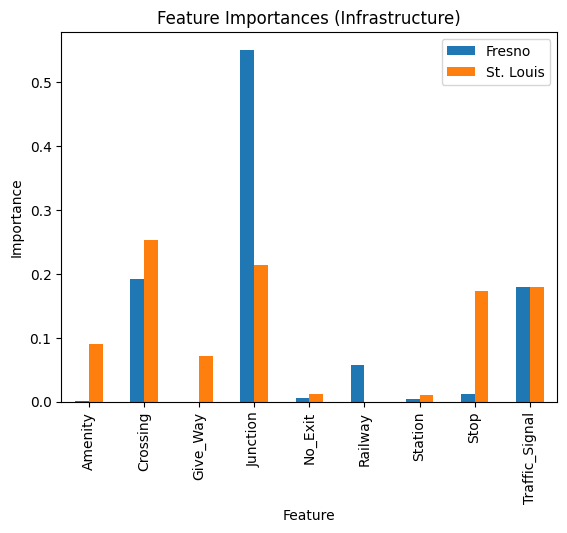

In [14]:
# plots for importances
importances1 = pd.Series([i for i, _ in sorted_importance_fresno1], index=[j for _, j in sorted_importance_fresno1])
importances2 = pd.Series([i for i, _ in sorted_importance_stlouis1], index=[j for _, j in sorted_importance_stlouis1])
overall = pd.DataFrame({"Fresno": importances1, "St. Louis": importances2})

ax = overall.plot(kind='bar')
plt.legend()
plt.title("Feature Importances (Infrastructure)")
plt.ylabel("Importance")
plt.xlabel("Feature")
plt.savefig("infrastructure_importances.png")
plt.show()
